# Pathway activity inference

scRNA-seq yield many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by infering pathway activities from prior knowledge.

In this notebook we showcase how to use `decoupler` for pathway activity inference with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available
from 10x Genomics [here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>  

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for visualization:
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

We can download the data easily using `scanpy`:

In [2]:
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can visualize the different cell types in it:

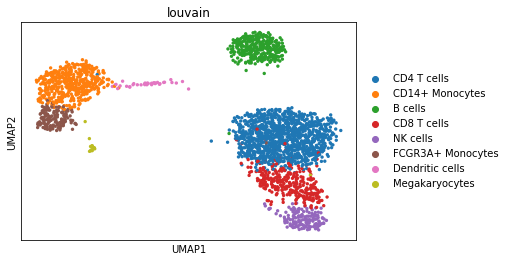

In [3]:
sc.pl.umap(adata, color='louvain')

## PROGENy model

[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction.
For this example we will use the human weights (mouse is also available) and we will use the top 100 responsive genes ranked by p-value. To access it we can use `decoupler`.

In [4]:
model = dc.get_progeny(organism='human', top=100)
model

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
1395,p53,CCDC150,-3.174527,7.396252e-13
1396,p53,LCE1A,6.154823,8.475458e-13
1397,p53,TREM2,4.101937,9.739648e-13
1398,p53,GDF9,3.355741,1.087433e-12


## Activity inference with Multivariate Linear Model

To infer activities we will run the Multivariate Linear Model method (`mlm`), but we could do it with any of the other available methods in `decoupler`. It models the observed gene expression by using a regulatory adjacency matrix (target genes x pathways) as covariates of the linear model. The values of this matrix are the associated interaction weights.
The obtained t-values of the fitted model are the activity scores.

To run `decoupler` methods, we need an input matrix (`mat`), an input prior knowledge
network/resource (`net`), and the name of the columns of `net` that we want to use.

In [5]:
dc.run_mlm(mat=adata, net=model, source='source', target='target', weight='weight', verbose=True)

58 features of mat are empty in 2635 samples, they will be ignored.
Running mlm on mat with 2638 samples and 13656 targets for 14 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.90s/it]


The obtained scores (t-values)(`mlm_estimate`) and p-values (`mlm_pvals`) are stored in the `.obsm` key:

In [6]:
adata.obsm['mlm_estimate']

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
AAACATACAACCAC-1,-0.254249,1.079791,-0.285906,-0.028353,-1.106584,-1.415070,-0.082578,-0.799087,-1.149092,0.683372,-0.574785,0.116901,0.123429,0.051064
AAACATTGAGCTAC-1,0.049356,1.810619,-0.642226,0.473845,0.044039,-2.655564,0.499077,-0.048742,-1.256668,-0.668830,0.662161,0.320902,-0.886260,-1.080493
AAACATTGATCAGC-1,-1.303848,0.994644,-1.424479,0.786483,0.760535,-1.422900,-0.092575,-0.283805,-0.821637,0.893210,0.002381,0.186219,-0.380405,-0.004127
AAACCGTGCTTCCG-1,-1.112302,0.619356,-0.535364,0.393064,5.351178,-1.143144,-1.695277,-0.320915,-0.656491,1.709201,-0.192290,-0.466818,-0.293868,-1.363734
AAACCGTGTATGCG-1,-0.024978,-0.952474,0.111260,0.429574,1.997764,1.380687,-0.279586,0.023845,-0.366084,-0.005061,0.697570,-0.186564,-1.324416,-0.745281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,-1.313532,1.637261,-0.521595,0.790193,5.909053,-1.263014,-2.046195,0.868877,-0.129425,2.279451,-0.395455,0.120465,0.379417,-0.726687
TTTCTACTGAGGCA-1,-0.089881,-0.277900,-0.336497,0.483560,1.307610,-0.530299,-0.635616,0.279144,-1.501107,0.174172,0.219880,0.288029,-0.357245,-0.364742
TTTCTACTTCCTCG-1,-0.384818,0.291916,-0.584801,-0.506899,0.398995,-0.762126,-1.212282,-1.737221,-0.691521,1.493315,1.031305,0.233905,-0.592073,-0.910929
TTTGCATGAGAGGC-1,-0.081163,1.160554,-0.053387,-0.944438,-1.008870,-1.162704,-0.632125,0.766052,-0.935325,0.303947,2.430733,-0.152342,0.621712,-0.182315


**Note**: Each run of `run_mlm` overwrites what is inside of `mlm_estimate` and `mlm_pvals`. if you want to run `mlm` with other resources and still keep the activities inside the same `AnnData` object, you can store the results in any other key in `.obsm` with different names, for example:

In [7]:
adata.obsm['progeny_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['progeny_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Visualization

To visualize the obtained scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract the activities from the `adata` object.

In [8]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')
acts

AnnData object with n_obs × n_vars = 2638 × 14
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example let's visualise the Trail pathway:

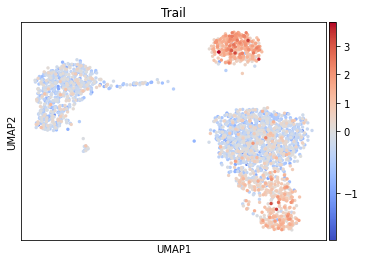

In [9]:
sc.pl.umap(acts, color='Trail', vcenter=0, cmap='coolwarm')

It seem that in B and NK cells, the pathway Trail, associated with apoptosis, is more active.

## Exploration

With `decoupler` we can also see what is the mean activity per group:

In [10]:
mean_acts = dc.summarize_acts(acts, groupby='louvain', min_std=0)
mean_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
B cells,-0.468620,0.331232,-0.417349,-0.158265,0.814644,-0.850410,-0.588561,-0.209756,-0.882239,0.643023,1.154483,-0.204471,-0.220058,-0.571772
CD14+ Monocytes,-0.757303,1.041441,-0.491022,0.747027,2.380898,-1.354828,-0.985024,-0.224320,-0.775338,1.474258,-0.269537,-0.301565,0.006913,-0.576483
CD4 T cells,-0.739280,0.398468,-0.442663,0.255920,0.944010,-0.813422,-0.495894,-0.644337,-0.891932,0.913994,-0.273603,0.058538,-0.229640,-0.631877
CD8 T cells,-0.729590,0.443396,-0.409557,0.302901,1.102024,-0.853103,-0.754845,-0.347034,-0.993045,1.228682,0.293810,0.072460,-0.133140,-0.677323
Dendritic cells,-0.689356,1.080140,-0.639010,0.825671,3.072018,-1.557169,-0.519228,-0.528199,-0.769999,0.858208,-0.339825,-0.484119,0.182676,-0.613223
FCGR3A+ Monocytes,-0.869172,1.303017,-0.634341,0.868262,3.638630,-1.599229,-1.155024,-0.105529,-1.160473,1.756404,-0.231644,-0.363514,-0.361645,-0.638332
Megakaryocytes,-0.539583,2.361184,-0.379758,1.339222,0.074742,-2.248966,-0.628353,-0.999684,0.006636,0.659785,-0.047438,-0.015523,0.957471,-0.315496
NK cells,-0.695226,0.543965,-0.211977,0.382988,2.203089,-0.974522,-1.161676,-0.094563,-1.086584,1.237731,0.729650,0.240034,-0.098274,-0.713052


We can visualize which group is more active using `seaborn`:

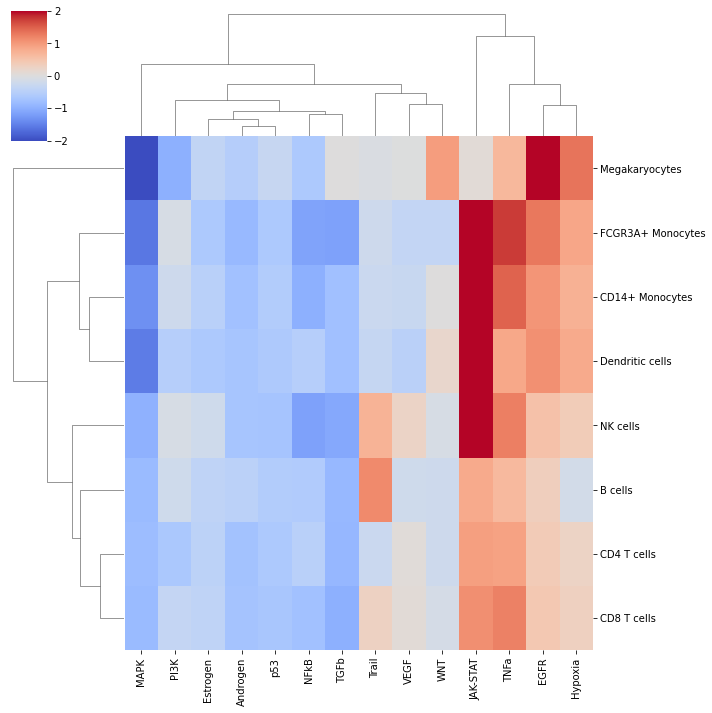

In [11]:
sns.clustermap(mean_acts, xticklabels=mean_acts.columns, vmin=-2, vmax=2, cmap='coolwarm')
plt.show()

In this specific example, we can observe that WNT to be more active in Megakaryocytes, and that Trail is more active in B and NK cells.